In [1]:
import numpy as np
import matplotlib
import glob
import matplotlib.pyplot as plt
import spiceypy as spice

from astropy.io import ascii
from astropy.table import Table
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [2]:
times = Table.read('times.dat', format='ascii', names=['et', 'bjd', 'moon', 'phase'])
print(times.info)

# load files that spice needs to figure out where things are
# in this case we need the body files (bsp), the timing file (tls) ,
# and then general Cassini space craft info (tsc) (I think?)
files = glob.glob('cass_kernels/*')
for file in files:
    spice.furnsh(file)
    print('Furnsh: '+file.split('/')[-1])

<Table length=6015>
 name  dtype 
----- -------
   et   int64
  bjd float64
 moon    str8
phase float64

Furnsh: co_1999312_01066_o_cru_v1.bsp
Furnsh: naif0012.tls
Furnsh: cas00171.tsc


In [3]:
poses = []
cposes = []
jposes = []

# spice.spkpos needs id numbers rather than names
jid = spice.bodn2c('Jupiter barycenter')
cid = spice.bodn2c('Cassini')

# for each time determine position of body with respect to Sun in J2000
# doesn't work with arrays I don't think so loop
for i,time in enumerate(times['et']):
    pos,_ = spice.spkpos(times['moon'][i], time, 
                                   'J2000', 'NONE', 'Sun')
    cpos,_ = spice.spkpos('Cassini', time, 'J2000', 'NONE', 'Sun')
    jpos,_ = spice.spkpos('Jupiter', time, 'J2000', 'NONE', 'Sun')
    poses.append(pos/1e6)
    cposes.append(cpos/1e6)
    jposes.append(jpos/1e6)

# need to do math so I need an array not a list
jposes = np.array(jposes)
poses = np.array(poses)
cposes = np.array(cposes)

In [4]:
#rotate so the Sun is always down
#x'=x\cos \theta -y\sin \theta 
#y'=x\sin \theta +y\cos \theta \,.
theta = np.pi/2-np.arctan(jposes.T[1]/jposes.T[0])

c_x = cposes.T[0]*np.cos(theta) - cposes.T[1]*np.sin(theta)
c_y = cposes.T[0]*np.sin(theta) + cposes.T[1]*np.cos(theta)

j_x = jposes.T[0]*np.cos(theta) - jposes.T[1]*np.sin(theta)
j_y = jposes.T[0]*np.sin(theta) + jposes.T[1]*np.cos(theta)

x = poses.T[0]*np.cos(theta) - poses.T[1]*np.sin(theta)
y = poses.T[0]*np.sin(theta) + poses.T[1]*np.cos(theta)

/Users/lcmayorga/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


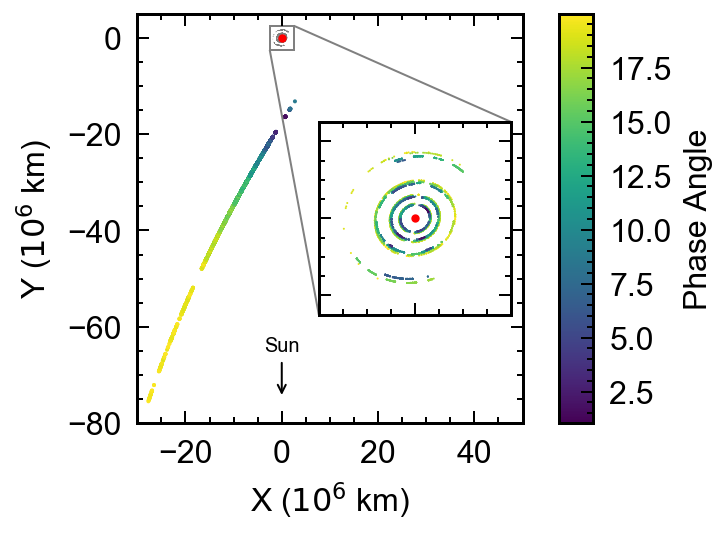

In [5]:
plt.close()
fig, ax = plt.subplots()
scat=ax.scatter(c_x-j_x, c_y-j_y, s=1, c=times['phase'])
ax.scatter((x-j_x),(y-j_y)*np.linspace(1,.9, len(y)), 
            s=.1, c='gray', edgecolor='none')
ax.scatter(0,0, color='red', s=10)
ax.annotate('Sun', xy=(0, -75), xytext=(0,-65), fontsize=10, 
            ha='center', arrowprops=dict(arrowstyle='->'))
ax.set_ylabel('Y ($10^6$ km)')
ax.set_xlabel('X ($10^6$ km)')
ax.set_xlim([-30,50])
ax.set_ylim([-80,5])
ax.set_aspect('equal')

plt.colorbar(scat, label='Phase Angle', aspect=12)

#create inset plot
axins = zoomed_inset_axes(ax, 8, loc=5)
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

axins.scatter((x-j_x)*np.linspace(1,.9, len(x)),(y-j_y)*np.linspace(1,.9, len(y)), 
            s=1, c=times['phase'], edgecolor='none')
axins.scatter(0,0, color='red', s=10)
axins.set_xlim([-2.5,2.5])
axins.set_ylim([-2.5,2.5])
plt.yticks(visible=False)
plt.xticks(visible=False)
axins.tick_params(which='both', labelsize='x-small')
axins.set_aspect('equal')

plt.tight_layout()
plt.show()